In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint

from IPython.display import clear_output
from IPython.display import display

sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath("../pax"))

from pax_utils import event_utils
from pax_utils import file_utils
from pax_utils import interaction_utils
from pax_utils import s1s2_utils
from pax_utils import waveform_utils

from pax import core
from pax import dsputils

from pax.configuration import load_configuration

pp = pprint.PrettyPrinter(depth=2)



In [2]:

####################################################################################################
####################################################################################################

f = plt.figure(figsize=(20, 10))

def processPklEvents(zipfilename):

    ################################################################################################
    ################################################################################################
    
    lst_pkl_files  = file_utils.getListOfPklFilesFromZipFile(zipfilename, nEventsPerFile)

    
    ################################################################################################
    ################################################################################################
    
    intr0  = None
    sum_wf = None
    event  = None

    df_zip_merged = pd.DataFrame()
    #df_zip_event  = pd.DataFrame()
    #df_zip_intr   = pd.DataFrame()
    #df_zip_s2s    = pd.DataFrame()
    
        
    ################################################################################################
    ################################################################################################
    
    for iPklFile in range(0, len(lst_pkl_files)):
    
        ############################################################################################
        ############################################################################################

        print("File: '" + str(zipfilename) + "'")
        print("   event_number: " + str(iPklFile))
        #clear_output(wait=True)
        
        
        ############################################################################################
        ############################################################################################

        jsonfilename = os.path.dirname(zipfilename) + '/pax_info.json'
        print("   CFG: '" + str(jsonfilename) + "'")
        
        #test = load_configuration()
        
        cfg = event_utils.getConfig(jsonfilename)
        
        
        #adc_to_pe = waveform_utils.getADCtoPE(cfg['DEFAULT'])
        
        
        
        
        ############################################################################################
        ############################################################################################
        
        pklfilename  = lst_pkl_files[iPklFile]
        event        = file_utils.getPaxEventFromPklFileInZipArchive(zipfilename, pklfilename)

      
        ############################################################################################
        ############################################################################################
        
        interactions  = event.interactions
        nInteractions = len(interactions)
        
        if (nInteractions != 1): continue

            
        ############################################################################################
        ############################################################################################

        intr0 = None
        
        if (len(interactions) > 0):
            
            intr0 = interactions[0]
            
       
     
            
            
        ############################################################################################
        ############################################################################################
        
        df_pkl_event  = event_utils.getEventDataFrameFromEvent(event)
        df_pkl_intr   = interaction_utils.getInteractionDataFrameFromEvent(event)
        df_pkl_s2s    = s1s2_utils.getS2integralsDataFrame(event, 127)
        
        #display(df_pkl_event)
        #display(df_pkl_intr)
        #display(df_pkl_s2s)
        
     
        ############################################################################################
        ############################################################################################
    
        #df_zip_event  = df_zip_event.append (df_pkl_event)
        #df_zip_intr   = df_zip_intr.append  (df_pkl_intr)
        #df_zip_s2s    = df_zip_s2s.append   (df_pkl_s2s)
        df_pkl_merged = df_pkl_event.merge(df_pkl_intr).merge(df_pkl_s2s)
        df_zip_merged = df_zip_merged.append(df_pkl_merged)
        
        #continue
      
    
         
        ############################################################################################
        # Summed Waveform from Event
        ############################################################################################
    
        summed_wafeform = waveform_utils.getSummedWaveformFromEvent(event)
        left            = event.main_s2.left
        right           = event.main_s2.right
        sum_intgr       = np.sum(summed_wafeform[left:right])
        corr            = intr0.s2_area_correction
        
        f = plt.figure(figsize=(10, 5))
        plt.plot(summed_wafeform)
        plt.axvline(left , color='r', linestyle='dashed')
        plt.axvline(right, color='r', linestyle='dashed')
        plt.xlim(left - 100, right + 500)
        
        print("Summed Waveform Integral: " + str(sum_intgr))
        print("Correction:               " + str(corr))
        
        
        ############################################################################################
        # Check Summed Waveforms
        ############################################################################################

        length = len(summed_wafeform)
        
        df_wfs     = waveform_utils.getS2waveformsAllChannels(event, cfg)
        arr_sum_wf = waveform_utils.getSummedWaveform(df_wfs)
        arr_sum_wf = waveform_utils.getPaddedWaveform(arr_sum_wf, left, right, length)
        
        
        #arr_sum_wf *= .01
        plt.plot(arr_sum_wf)

        
        ############################################################################################
        ############################################################################################
          
        sum_test = 0
        
        for i in range(0, len(arr_sum_wf)):
            
            sum_test += arr_sum_wf[i]
            
        
        print("Summed Waveform Test: " + str(sum_test))
        
        
        ############################################################################################
        ############################################################################################
          
        display(df_wfs[0:1][:])

        
        
        
        ############################################################################################
        ############################################################################################
    
        continue
            
    
    ################################################################################################
    ################################################################################################
    
    #plt.legend()
    
    df_zip_merged.reset_index(inplace=True, drop=True)
       
    return df_zip_merged, event, intr0, sum_wf

    

File: '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 0
   CFG: '../pax_run/pax_output/instructions_000000/pax_info.json'
File: '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 1
   CFG: '../pax_run/pax_output/instructions_000000/pax_info.json'
Summed Waveform Integral: 699.917
Correction:               1.8745586609917786
Summed Waveform Test: 690.827731839


,channel,left,right,sum,raw_data
0,0,105380,105971,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,event_number,event_n_pulses,event_pulses_count,intr_count,intr_x,intr_y,intr_x_nn,intr_y_nn,intr_xy_posrec_algorithm,intr_drift_time,...,s2_area_117,s2_area_118,s2_area_119,s2_area_120,s2_area_121,s2_area_122,s2_area_123,s2_area_124,s2_area_125,s2_area_126
0,1,400,400,1,3.117168,-16.583333,3.2708,-16.607226,PosRecTopPatternFit,400890.0,...,6.564991,0.0,0.400128,2.742959,3.460256,8.159419,38.424745,15.890681,1.354377,10.354574


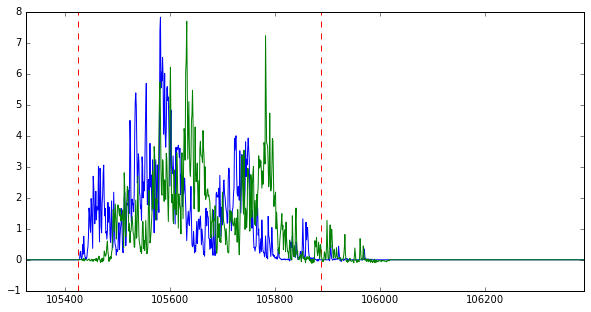

In [3]:

####################################################################################################
####################################################################################################

zipfilename    = '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
nEventsPerFile = 2


df_zip_merged, event, intr, wf_sum = processPklEvents(zipfilename)

#wfs = event.sum_waveforms

display(df_zip_merged)

#print(len(event.peaks))
#print(len(event.pulses))
#print(len(wfs))

#print(len(event.interactions))
#print(len(event.peaks))
#print(len(event.sum_waveforms))

    